In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import yaml
# from tqdm import tqdm
from pprint import pprint
from src.stereo_calibration_utils import *
from src.cameras import *
%load_ext autoreload
%autoreload 2

# Introduction

We assume you have followed the hardware setup and camera calibration tutorial to collect the calibration dataset and used it in the calibration notebook to get the camera poses in the world coordinate. Given this, this notebook performs an offline reconstruction of the positions observed during an experiment.   

# Step0: Load the Dataset and Camera Intrinsic Parameters
Here we want a manager class to hold the seen markers through the tracker cameras, the time stamps of the observations and the parameters of the camera.

In [2]:
dataset_dir = 'sample_dataset/multi-camera-reconstructin-dataset.pckl'
camera_intrinsic_dir = 'sample_dataset/intrinsics/'

cam_dm = cameraDataManager(dataset_dir, camera_intrinsic_dir,
                           ports = [5000, 5001, 5002], data_idx= 3)  

synchronized_paths = cam_dm.getSynchronizedSamples('5002-0')
synchronized_paths.keys()

dict_keys(['5000-0', '5000-1', '5001-0', '5001-1', '5002-0', '5002-1'])

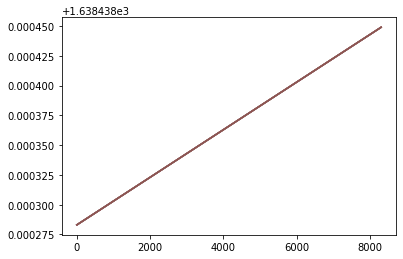

In [3]:
for key in cam_dm.pixel_locations.keys():
    plt.plot(cam_dm.stamp_per_camera[key][cam_dm.syncMap('5002-0',key)[:,1]])

# Setep1: Reconstruct Using Geometrical Methods

Hear we first triangulate the marker locations for each camera pair and then align them using the alignment parameters that we computed in the calibration notebook. 

In [4]:
# All stereo pairs in the system
stereo_parms_dir = 'output/pair_extrinsics/ba/'
params = os.listdir(stereo_parms_dir)
ext_params = {}
for param in params:
    with open(os.path.join(stereo_parms_dir, param), 'rb') as f:
        ext_params[param.split('.')[0].split('ext_')[-1]] = pickle.load(f)
pprint([key for key in ext_params.keys()])

['5000-1->5001-0',
 '5001-1->5002-1',
 '5000-0->5001-1',
 '5000-0->5001-0',
 '5000-1->5002-1',
 '5000-0->5000-1',
 '5000-0->5002-0',
 '5000-1->5001-1',
 '5001-1->5002-0',
 '5000-1->5002-0',
 '5000-0->5002-1',
 '5001-0->5002-0',
 '5001-0->5001-1',
 '5002-0->5002-1',
 '5001-0->5002-1']


### Load the Marker Observations

In [5]:
# Take the 5002-0 as the reference camera against which all other cameras are synchronized
sync_pixels = cam_dm.getSynchronizedSamples('5002-0', undist=False)
sync_pixels.keys()
sync_pixels['5002-1'].shape

(8301, 2)

5000-1->5001-0


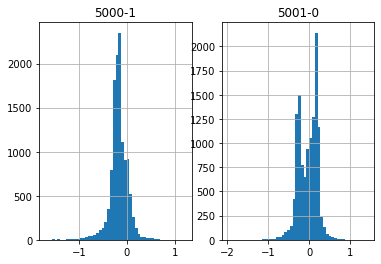

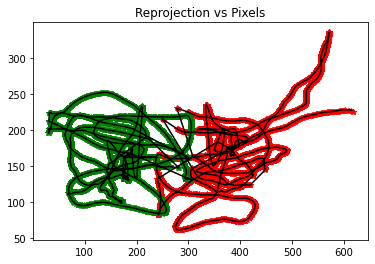

-----------------------------------------
5001-1->5002-1


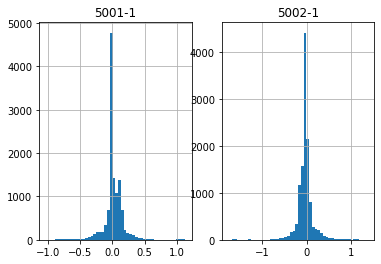

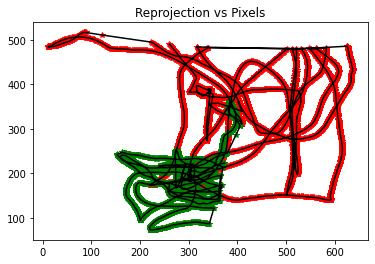

-----------------------------------------
5000-0->5001-1


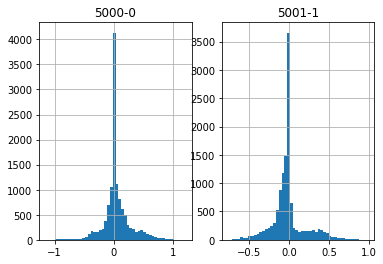

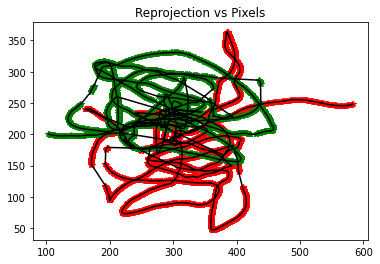

-----------------------------------------
5000-0->5001-0


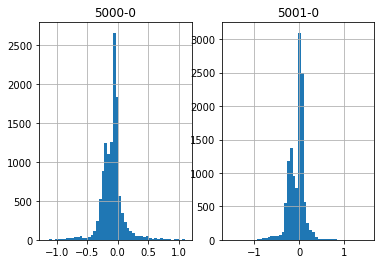

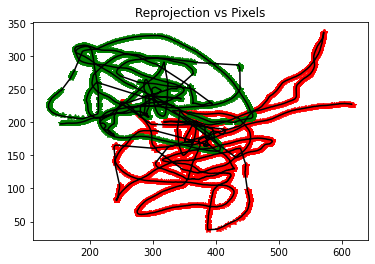

-----------------------------------------
5000-1->5002-1


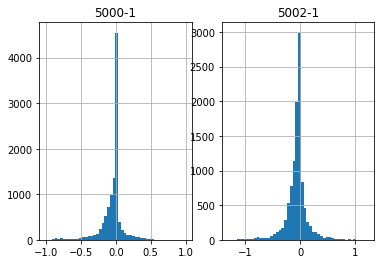

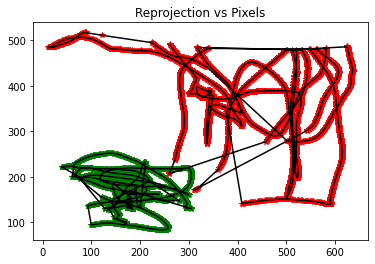

-----------------------------------------
5000-0->5000-1


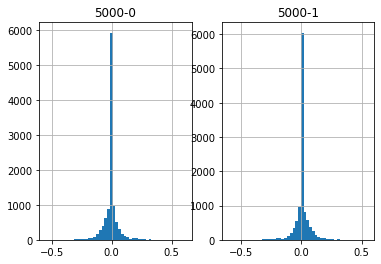

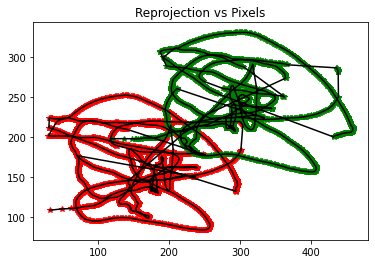

-----------------------------------------
5000-0->5002-0


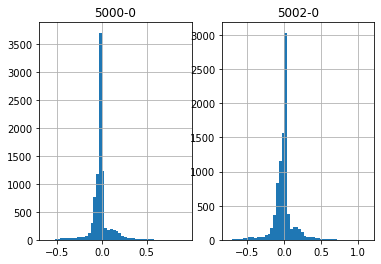

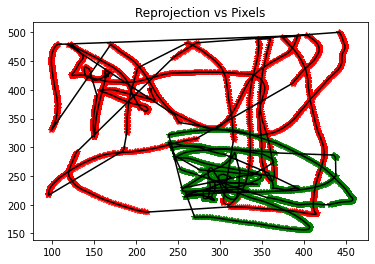

-----------------------------------------
5000-1->5001-1


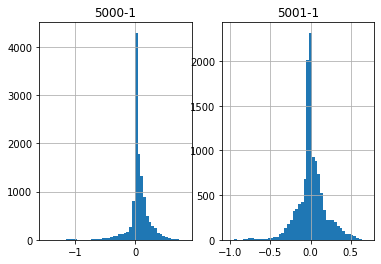

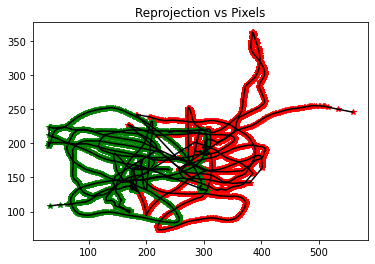

-----------------------------------------
5001-1->5002-0


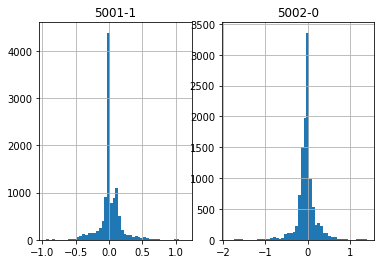

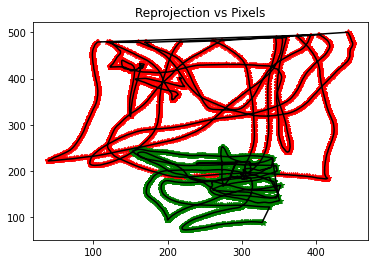

-----------------------------------------
5000-1->5002-0


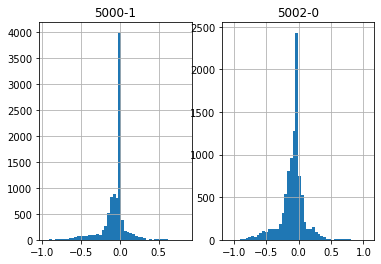

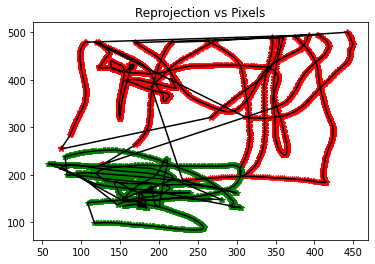

-----------------------------------------
5000-0->5002-1


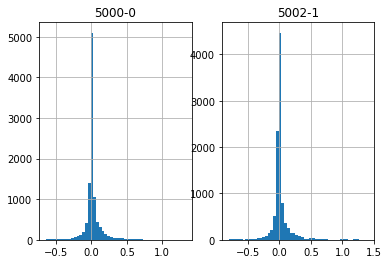

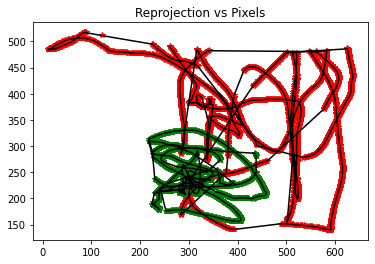

-----------------------------------------
5001-0->5002-0


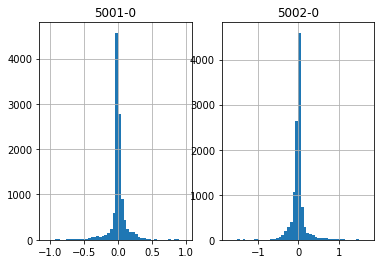

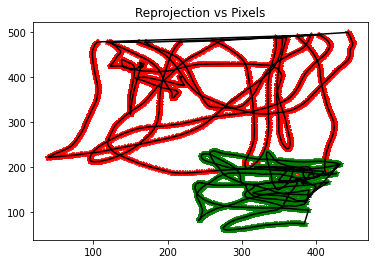

-----------------------------------------
5001-0->5001-1


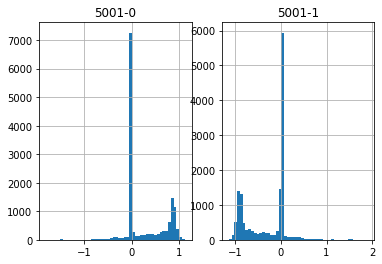

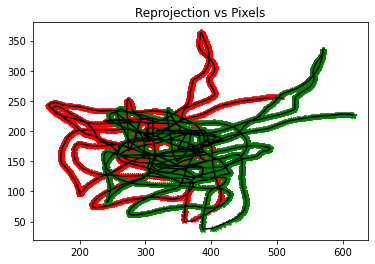

-----------------------------------------
5002-0->5002-1


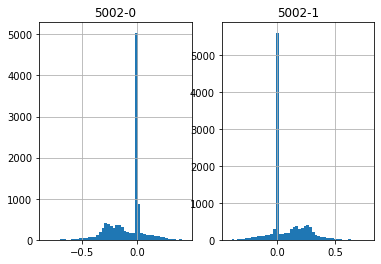

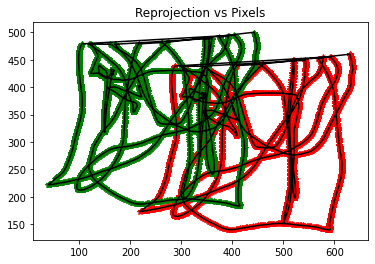

-----------------------------------------
5001-0->5002-1


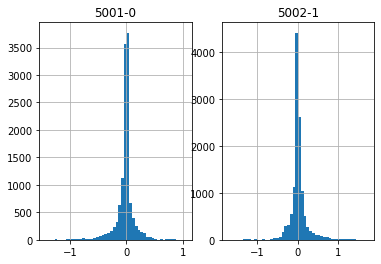

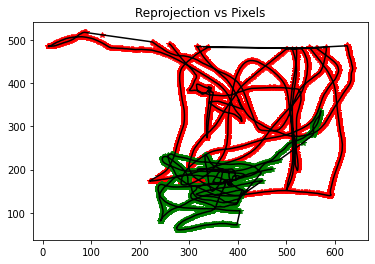

-----------------------------------------


In [6]:
stereo_parms_dir = 'output/pair_extrinsics/ba/'
camera_intrinsics_dir = 'sample_dataset/intrinsics'

results = {}
for pair in ext_params.keys():
    print(pair)
    # Load the geometrical extrinsics computed in the previous section
    c1, c2 = pair.split('->')
    # Load the camera intrinsics 
    
    # Get the synchronized and raw pixel data of c1-c2 pair
    x1, x2 = sync_pixels[c1], sync_pixels[c2]
    result = -np.ones((x1.shape[0],3))
    reprojection_error = np.ones((x1.shape[0]))

    idx1 = np.all(x1!=np.array([-1,-1]), axis=-1)
    idx2 = np.all(x2!=np.array([-1,-1]), axis=-1)
    idx = np.where(idx1*idx2)

    x1 = x1[idx,...].squeeze()
    x2 = x2[idx,...].squeeze()
    
    #Load the extrinsic parametes 
    with open(os.path.join(stereo_parms_dir, f'ext_{c1}->{c2}.pckl'),'rb') as f:
        geom_ext = pickle.load(f)
    
    P1, P2 = geom_ext['P1'], geom_ext['P2']
    R,t = geom_ext['R|T']
   
    # Make a stereo camera object to reconstruct the 3D positions of the landmarks
    cam1_yaml = os.path.join(camera_intrinsics_dir,f'{c1}.yaml')
    cam2_yaml = os.path.join(camera_intrinsics_dir,f'{c2}.yaml')
    
    stereoCamera = StereoCamera(cam1_yaml, cam2_yaml, P1, P2)
    
    # Undistrot the raw pixel locations
    x1_undist, x2_undist = stereoCamera.undist(x1, x2)
    
    # Triangulate the 3D positions of the landmarks
    landmarks = stereoCamera.triangulate(x1_undist, x2_undist, undist=False)
    result[idx,...]=landmarks.squeeze()[:,0:3]
    
    # Plot and save the error distribution before BA
    xi_reproj = (P1 @ landmarks.T).T
    xi_reproj = (xi_reproj / xi_reproj[:,-1].reshape(-1,1))[:,0:2]

    xj_reproj = (P2 @ landmarks.T).T
    xj_reproj = (xj_reproj / xj_reproj[:,-1].reshape(-1,1))[:,0:2]
    ej = (xj_reproj - x2_undist[:,0:2]).reshape(-1,1)
    ei = (xi_reproj - x1_undist[:,0:2]).reshape(-1,1)
    
    reprojection_error[idx,...] = (np.linalg.norm(xj_reproj - x2_undist[:,0:2], axis = -1)+
                          np.linalg.norm(xi_reproj - x1_undist[:,0:2], axis = -1))/2

    # Plot the reprojection error distribution
    fig,ax=plt.subplots(1,2)
    _ = ax[0].hist(ei, bins=50)
    _ = ax[0].set_title(c1)
    ax[0].grid(True)

    _ = ax[1].hist(ej, bins=50)
    _ = ax[1].set_title(c2)
    ax[1].grid(True)
    plt.show()
    
    # Plot the reprojections of the landmarks on the image
    plt.figure()
    plt.title('Reprojection vs Pixels')
    plt.plot(xj_reproj[:,0],xj_reproj[:,1],'r*')
    plt.plot(xi_reproj[:,0],xi_reproj[:,1],'g*')
    plt.plot(x1_undist[:,0],x1_undist[:,1],'k')
    plt.plot(x2_undist[:,0],x2_undist[:,1],'k')
    plt.show()
    c1 = c1.replace('_','-')
    c2 = c2.replace('_','-')
    results[f'{c1}->{c2}']={'landmarks':result, 'error':reprojection_error.reshape(-1,1)}
    print('-----------------------------------------')


In [7]:
from pprint import pprint
pprint([f'pair {key}: {[k for k in results[key].keys()]}' for key in results.keys()])

["pair 5000-1->5001-0: ['landmarks', 'error']",
 "pair 5001-1->5002-1: ['landmarks', 'error']",
 "pair 5000-0->5001-1: ['landmarks', 'error']",
 "pair 5000-0->5001-0: ['landmarks', 'error']",
 "pair 5000-1->5002-1: ['landmarks', 'error']",
 "pair 5000-0->5000-1: ['landmarks', 'error']",
 "pair 5000-0->5002-0: ['landmarks', 'error']",
 "pair 5000-1->5001-1: ['landmarks', 'error']",
 "pair 5001-1->5002-0: ['landmarks', 'error']",
 "pair 5000-1->5002-0: ['landmarks', 'error']",
 "pair 5000-0->5002-1: ['landmarks', 'error']",
 "pair 5001-0->5002-0: ['landmarks', 'error']",
 "pair 5001-0->5001-1: ['landmarks', 'error']",
 "pair 5002-0->5002-1: ['landmarks', 'error']",
 "pair 5001-0->5002-1: ['landmarks', 'error']"]


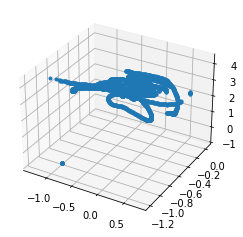

In [8]:
#Plot one of the reconstructions for sanity check
# %matplotlib
pair = '5000-0->5000-1'
plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(results[pair]['landmarks'][:,0],
          results[pair]['landmarks'][:,1],
          results[pair]['landmarks'][:,2], '.')
plt.show()

## Step2: Align the Pointclouds

Now, we use the relative transformations between the cameras to align the generated point clouds in the above.

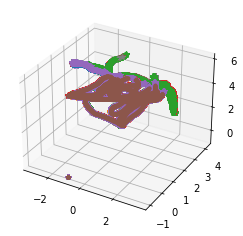

In [9]:
with open('output/alignment/pair_alignments.pckl', 'rb') as f:
    alignment_params = pickle.load(f)

ref_pair = '5002-0->5002-1'
P1 = results[ref_pair]['landmarks'] #reference point cloud

plt.figure()
ax = plt.axes(projection='3d')
reconstructions_aligned = []

for pair in results:
    P2 = results[pair]['landmarks']
    
    param = alignment_params[f'{ref_pair}_{pair}'] 
    s = param['s']
    R = param['R']
    t = param['t']

    invisible_idx = np.where(P2==[-1,-1,-1])[0]
    a_with_marker = np.sum(P1,axis=-1)!=-3
    b_with_marker = np.sum(P2,axis=-1)!=-3
    a_b_with_marker = np.logical_and(a_with_marker, b_with_marker)
    idx = np.where(a_b_with_marker)
    
    A = P1[a_b_with_marker,:]
    B = P2[a_b_with_marker,:]
    
    P2_prime =( s * R @ P2.T + t.reshape(3,1)).T
    P2_prime[invisible_idx,:] = -np.ones((1,3))
    
    reconstructions_aligned.append(P2_prime)
    ax.plot3D(P2_prime[:,0],P2_prime[:,1],P2_prime[:,2],'*')
    
ax.plot3D(P1[:,0],P1[:,1],P1[:,2],'.')


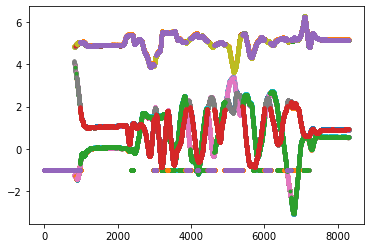

In [10]:
for path in reconstructions_aligned:
    plt.plot(path,'.')

# Step3: Fuse the Aligned Point Clouds

In this section, we make a unified point cloud as the average of all the aligned point clouds from the previous step.

In [11]:
pcs = []

for pc in reconstructions_aligned:  
    #Zero out samples with no marker (indicated with [-1, -1, -1])
    idx_null = np.where(np.all(pc==-1, axis = -1))[0]
    #Scale the point cloud
    pc[idx_null,...] = [0, 0, 0]
    pcs.append(pc)
        
pcs = np.stack(pcs)
#How many valid samples do we have for each time stamp
avg_den = np.count_nonzero(np.all(pcs!=0, axis = -1), axis = 0).reshape(-1,1)
#Compute the average for each time stamp and avoid dividing by zero if no markers are visible
fused_pc = np.sum(pcs, axis = 0)
#Note, we should not divide by zero
fused_pc[np.where(avg_den!=0)[0]] /= avg_den[np.where(avg_den!=0)[0]]
#reset the indication value of no maker visible samples to -1s
fused_pc[np.where(avg_den==0)[0],...]=[-1,-1,-1]

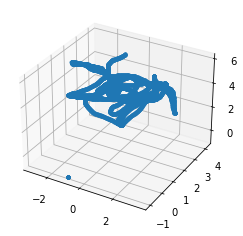

In [12]:
#Plot one of the reconstructions for sanity check
# %matplotlib
plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(fused_pc[:,0],
          fused_pc[:,1],
          fused_pc[:,2], '.')
plt.show()

# Step4: Bundle Adjustment for All Cameras

Finally, we use the geometrical estimation from the previous section and solve a BA problem given the camera poses and covariance parameters from the calibration notebook. The factor graph generated in this section as constructed from the camera poses using prior pose factors and general projection factors that connect the camera poses to the observed landmarks.

In [13]:
calib_data = 'sample_dataset/multi-camera-reconstructin-dataset.pckl'

cam_dm = cameraDataManager(calib_data, 
                           'sample_dataset/intrinsics/',ports = [5000, 5001, 5002], data_idx= 3)  

synchronized_paths = cam_dm.getSynchronizedSamples('5002-0',undist=True)

In [14]:
with open('output/alignment/cam_poses.pckl', 'rb') as f:
    camera_poses = pickle.load(f)

In [15]:
import gtsam
from gtsam.symbol_shorthand import B, V, X, L

class multiCameraBA():
    def __init__(self, camera_poses, camera_dm, ref_camera = '5002-0'):
        self.reference_camera = ref_camera
        #Load the geometrical extrinsic parameters calculated from the previous section
        self.camera_poses = camera_poses
        #Extract the keys
        self.extractExtrinsicKeys(camera_poses)
        #Load the camera parameters as GTSAM Cal3_S2 objects 
        camModels = cam_dm.camModels
        self.Ks = {key:gtsam.Cal3_S2(camModels[key].P[0,0], camModels[key].P[1,1], 0, \
                                     camModels[key].P[0,2], camModels[key].P[1,2]) \
                   for key in camModels.keys()}
        
        # Here, we're assuming identical noises for all cameras (0.5 pixels)
        self.camNoises = {key:gtsam.noiseModel.Isotropic.Sigmas( np.array([0.2, 0.2])) 
                          for key in camModels.keys()}
             
                
    def extractExtrinsicKeys(self, camera_poses):
        #Extract all extrinsic pairs
        self.pair_keys = [k for k in camera_poses['cov'].keys()]
        #What camera IDs do we have?
        all_keys = np.stack([k.split('->') for k in ext_params.keys()]).reshape(-1)
        
        self.cam_ids = []     
        _ = [self.cam_ids.append(key) if key not in self.cam_ids else None for key in all_keys]
        #Make dictionaries to convert camera IDs to pose keys
        self.cam_id_to_key = {i:key for i,key in enumerate(self.cam_ids)}
        self.key_to_cam_id = {key:i for i,key in enumerate(self.cam_ids)}
        
    def addUnaryPosePrior(self, T, noise, key):
        self.graph.push_back(gtsam.PriorFactorPose3(key, T, noise))         

    def addProjectionFactor(self, K, z, noise, camera_key, landmark_key):
        self.graph.push_back(gtsam.GenericProjectionFactorCal3_S2( z.reshape(2,1),noise, camera_key, landmark_key, K))
            
    def run(self, pixels, recons_init):
            '''Take the synchronized pixels and the intial reconstructions from 
               the geometrical method and preform BA'''
            
            means = self.camera_poses['mean']
            cov = self.camera_poses['cov']
                        
            self.graph = gtsam.NonlinearFactorGraph()
            self.initial = gtsam.Values()
            
            for key in means.keys():
                self.addUnaryPosePrior(gtsam.Pose3(means[key]), 
                gtsam.noiseModel.Isotropic.Covariance(cov['5000-0']), X(self.key_to_cam_id[key]))
                self.initial.insert(X(self.key_to_cam_id[key]), gtsam.Pose3(means[key]))
            
            pixel_keys = [key for key in pixels]
            num_of_landmarks = pixels[pixel_keys[0]].shape[0]

            l_index = 0
            self.lz_index_map = []
            for n in range(num_of_landmarks):
                #Extract the current observation i for all camera
                z = np.stack([pixels[key][n,...] for key in pixel_keys])
                p_init = recons_init[n,...]

                # How many cameras can see the marker at this moment?
                visibility_number = np.count_nonzero(np.all(z!=-1, axis = -1))
                # Add the landmark to the graph only if at least two cameras can simultaneously see the marker
                if visibility_number > 1:
#                   Add the valid landmark observations to the graph
                    for i,key in enumerate(pixel_keys):
                        if np.all(z[i,...]!=-1, axis=-1): # The marker should be visible by at least two cameras 
#                             print(f'Adding observation of camera {key} to the graph.')

                            self.addProjectionFactor(self.Ks[key], z[i,:], self.camNoises[key],\
                                                 X(self.key_to_cam_id[key]), L(l_index))
#                             print(f'Connecting landmark L({l_index}) to X({self.key_to_cam_id[key]})')

                    self.initial.insert(L(l_index), gtsam.Point3(x=p_init[0], y=p_init[1], z=p_init[2]))
                    self.lz_index_map.append((l_index, n))
                    l_index+=1
                            
    
            self.lz_index_map=np.stack(self.lz_index_map)
            params = gtsam.GaussNewtonParams()
            optimizer = gtsam.GaussNewtonOptimizer(self.graph, self.initial, params)
            self.result = optimizer.optimize()
            marginals = gtsam.Marginals(self.graph, self.result)
            i = 0
            self.L = []
            self.R = self.result.atPose3(X(1)).matrix()[0:3,0:3].reshape(3,3)
            self.t = self.result.atPose3(X(1)).matrix()[0:3,-1] 
            for i in range(l_index):
                if self.result.exists(L(i)):
                    self.L.append(self.result.atPoint3(L(i)))
            self.L = np.stack(self.L)
            camPoses = {}  
            camCovariances = {}
            for key in self.key_to_cam_id:
                R = self.result.atPose3(X(self.key_to_cam_id[key])).matrix()[0:3,0:3].reshape(3,3)
                t = self.result.atPose3(X(self.key_to_cam_id[key])).matrix()[0:3,-1] 
                camPoses[key] = gtsam.Pose3(gtsam.Rot3(R), t).matrix()
                camCovariances[key] = gtsam.noiseModel.Gaussian.Covariance(
                    marginals.marginalCovariance(X(self.key_to_cam_id[key]))).covariance() 
            return camPoses, camCovariances

In [16]:
ds_ratio = 1
synchronized_paths_ds = {}
idx_ds = [i*ds_ratio for i in range(fused_pc.shape[0]//ds_ratio)]
fused_pc_ds = fused_pc[idx_ds,...]

for key in synchronized_paths:
    synchronized_paths_ds[key] = synchronized_paths[key][idx_ds,...]

In [17]:
ba = multiCameraBA(camera_poses, cam_dm)
camPoses, camCovariances = ba.run(synchronized_paths_ds,fused_pc_ds)

In [21]:
%matplotlib
np.stack(ba.lz_index_map).shape, ba.L.shape

reconstruction = -np.ones_like(fused_pc_ds)
reconstruction[np.stack(ba.lz_index_map)[:,1]] = ba.L[np.stack(ba.lz_index_map)[:,0]]
plt.plot(reconstruction)
plt.plot(fused_pc_ds, '--')

Using matplotlib backend: QtAgg


Show the camera poses and estimated landmark positions in a 3D scene.

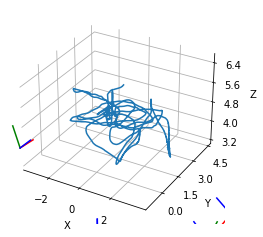

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from pytransform3d import rotations as pr
from pytransform3d import transformations as pt
from pytransform3d.transform_manager import TransformManager


random_state = np.random.RandomState(0)

cam_poses = [pt.transform_from_pq(np.hstack((camPoses[key][0:3,-1],
               pr.quaternion_from_matrix(camPoses[key][0:3,0:3]) ))) for key in camPoses.keys()]


tm = TransformManager()
for i,pose in enumerate(cam_poses):
    tm.add_transform(f"cam{i}", "world", pose)
    
ax = tm.plot_frames_in("world", s=1, show_name=False)
ax.set_xlim((min(ba.L[:,0])-0.5, max(ba.L[:,0])+0.5))
ax.set_ylim((min(ba.L[:,1])-0.5, max(ba.L[:,1])+0.5))
ax.set_zlim((min(ba.L[:,2])-0.5, max(ba.L[:,2])+0.5))
ax.plot3D(ba.L[:,0], ba.L[:,1], ba.L[:,2])
plt.show()

# Sanity Check
The check the correctness of the estimated camera poses and landmark 3D positions, reproject the landmarks back on the the image planes and compare against the real observations (camera pixels). Ideally, these two sets of positions must be as close as possible.

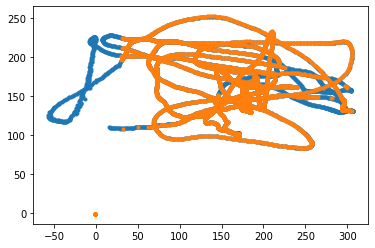

In [27]:
landmarks  = np.hstack([ba.L, np.ones((ba.L.shape[0],1))])

T = np.linalg.inv(camPoses['5000-1'])
R = T[0:3, 0:3]
t = T[0:3, -1]
P1 = cam_dm.camModels['5000-1'].P[0:3,0:3]
P1 = P1@np.hstack([R,t.reshape(3,1)])
xi_reproj = (P1 @ landmarks.T).T
xi_reproj = (xi_reproj / xi_reproj[:,-1].reshape(-1,1))[:,0:2]

plt.plot(xi_reproj[:,0], xi_reproj[:,1],'.')
plt.plot(synchronized_paths['5000-1'][:,0], synchronized_paths['5000-1'][:,1],'.')